# Visualize target and prior distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


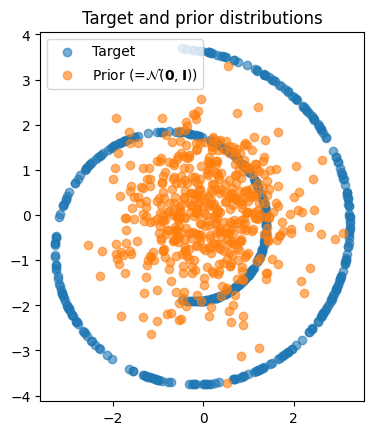

In [32]:
%load_ext autoreload
%autoreload 2

from dataset import TwoDimDataClass, get_data_iterator
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import io

target_ds = TwoDimDataClass(dataset_type='swiss_roll', 
                            N=1000000, 
                            batch_size=256)
# normalize the target dataset
prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

num_vis_particles = 500
sample_f = target_ds[0:num_vis_particles]
sample_b = prior_ds[0:num_vis_particles]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', 'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

# Define a VAE model

In [33]:
# hyperparameters #
# Don't change it
device = "cuda:0"
config = {
    # "num_diffusion_steps": 1000,
    "z_dim": 2,
    # "dim_hids": [128, 128, 128],
    "dim_hids": [256, 128],
    "num_iters_in_e_step": 15,
    "lr_m": 2e-3,
    "lr_e": 1e-1,
    "batch_size": 128,
    "num_train_iters": 5000,
    # "num_train_iters": 10000,
    "device": device,
}

class Encoder(nn.Module):
    def __init__(self, dim_in=2, dim_out=config["z_dim"], dim_hids=config["dim_hids"]):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_hids = dim_hids
        
        # Reverse dimensions for encoder
        dim_hids = dim_hids[::-1]
        
        layers = []
        prev_dim = dim_in
        for dim in dim_hids:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            prev_dim = dim
            
        self.shared = nn.Sequential(*layers)
        
        # Separate layers for mean and log_var
        self.fc_mu = nn.Linear(prev_dim, dim_out)
        self.fc_log_var = nn.Linear(prev_dim, dim_out)
        
    def forward(self, x):
        h = self.shared(x)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var


class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var
    
    def sample(self, n_examples):
        z = torch.randn(n_examples, self.encoder.dim_out, device=device)
        return self.decoder(z)
    

class Decoder(nn.Module):
    def __init__(self, dim_in = config["z_dim"], dim_out = 2, dim_hids = config["dim_hids"]):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_hids = dim_hids
        layers = []
        prev_dim = dim_in
        for dim in dim_hids:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, dim_out))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.layers(z)
    
    def compute_loss(self, z, x):
        return F.mse_loss(self.forward(z), x)


    def sample(self, n_examples):
        z_dim = self.dim_in
        z = torch.randn(n_examples, z_dim, device=device)
        return self.forward(z)

# Initialize the model
encoder = Encoder().to(device)
decoder = Decoder().to(device)
vae = VAE(encoder, decoder).to(device)


def vae_loss(x_recon, x, mu, log_var):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_recon, x)
    
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    
    # Total loss
    loss = recon_loss + 0.1 * kl_loss
    return loss


# print("VAE model params: ", sum(p.numel() for p in vae.parameters()))

In [34]:
# # Define the VAE architecture
# class VAE(nn.Module):
#     def __init__(self, input_dim=2, hidden_dim=256, latent_dim=2):
#         super(VAE, self).__init__()

#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.latent_dim = latent_dim
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU()
#         )
        
#         # Latent space parameters
#         self.fc_mu = nn.Linear(hidden_dim, latent_dim)
#         self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, input_dim)
#         )
        
#     def encode(self, x):
#         h = self.encoder(x)
#         return self.fc_mu(h), self.fc_var(h)
    
#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mu + eps * std
    
#     def decode(self, z):
#         return self.decoder(z)
    
#     def forward(self, x):
#         mu, log_var = self.encode(x)
#         z = self.reparameterize(mu, log_var)
#         return self.decode(z), mu, log_var
    
#     def sample(self, n_examples):
#         z_dim = self.latent_dim
#         z = torch.randn(n_examples, z_dim, device=device)
#         return self.decode(z)

# latent_dim = 2
# vae = VAE(hidden_dim=256, latent_dim=latent_dim).to(device)

# Training

loss: 3.9780:   0%|          | 0/5000 [00:00<?, ?it/s]

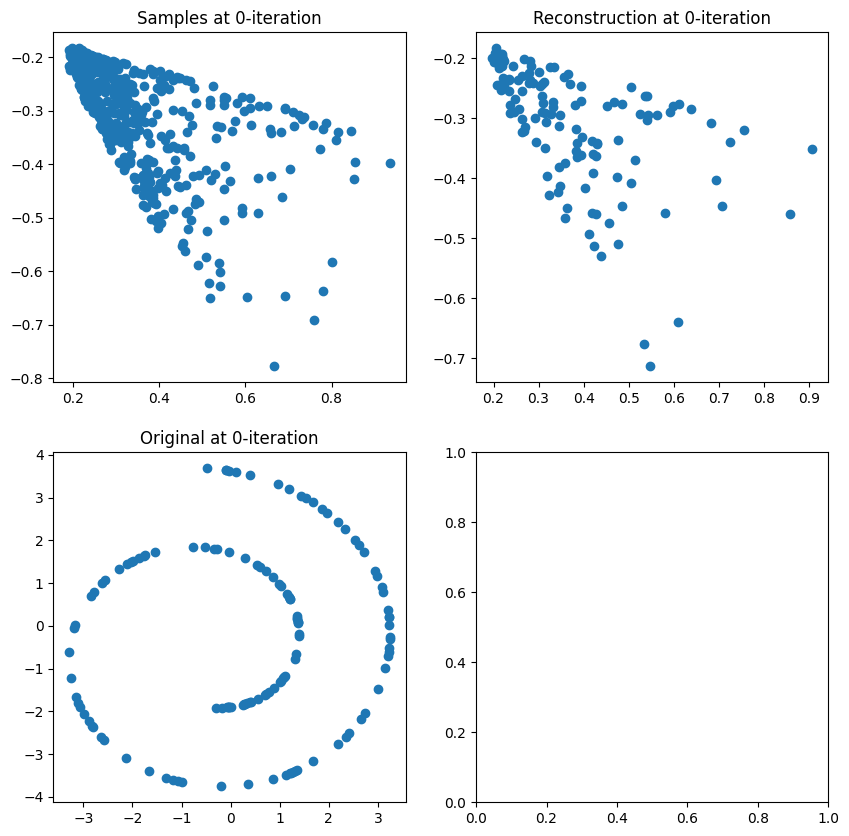

loss: 0.2182: 100%|█████████▉| 4986/5000 [00:11<00:00, 438.26it/s]

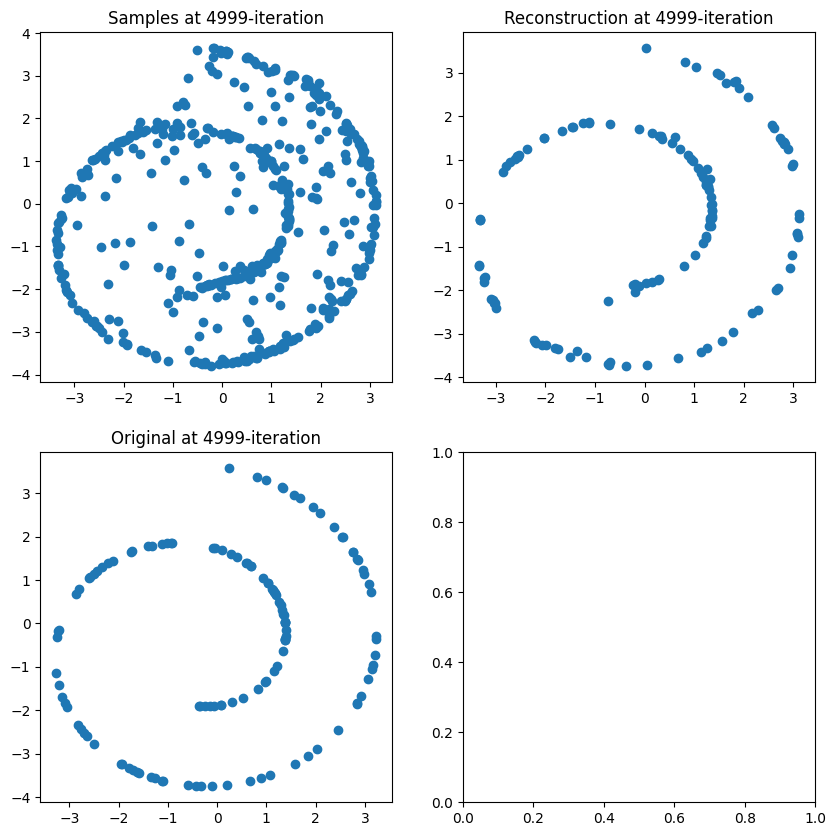

loss: 0.2182: 100%|██████████| 5000/5000 [00:12<00:00, 408.73it/s]


interactive(children=(IntSlider(value=1, description='index', max=1), Output()), _dom_classes=('widget-interac…

Output()

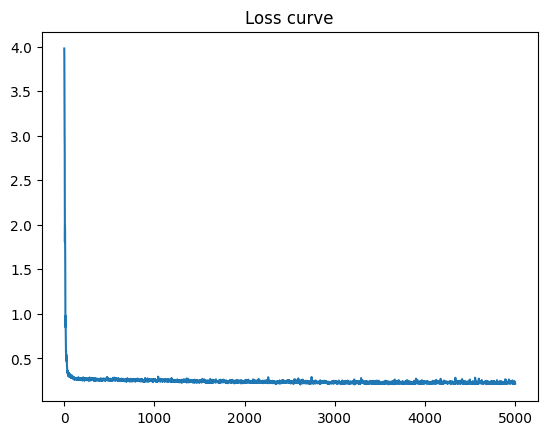

In [35]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# Initialize the model.

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(vae.parameters(), lr=config["lr_m"])
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()
        
        batch_x = next(train_iter)
        batch_x = batch_x.to(device)

        # Forward pass
        x_recon, mu, log_var = vae(batch_x)
        
        # Calculate loss
        loss = vae_loss(x_recon, batch_x, mu, log_var)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        pbar.set_description(f"loss: {loss.item():.4f}")
        
        losses.append(loss.item())
        
        if step % 4999 == 0:
            with torch.no_grad():
                x_recon, mu, log_var = vae(batch_x)
                x_recon = x_recon.cpu()
                x0 = vae.sample(n_examples=num_vis_particles).cpu()
                # figure size
                figsize = (10, 10)
                fig, ax = plt.subplots(2,2, figsize=figsize)
                ax[0,0].scatter(x0[:,0], x0[:,1])
                ax[0,0].set_title(f"Samples at {step}-iteration")
                ax[0,1].scatter(x_recon[:,0], x_recon[:,1])
                ax[0,1].set_title(f"Reconstruction at {step}-iteration")
                batch_x = batch_x.cpu()
                ax[1,0].scatter(batch_x[:,0], batch_x[:,1])
                ax[1,0].set_title(f"Original at {step}-iteration")
                plt.show()
                img = figure2image(fig)
                images.append(img)
                
except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

# Evaluation

DDPM Chamfer Distance: 0.2437


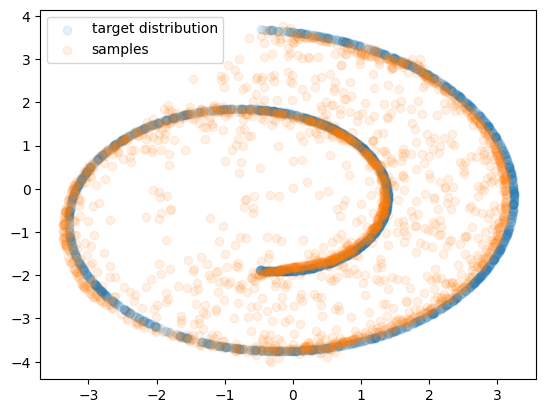

In [36]:
# You will get full credits if your chamfer distance is lower than 20.
# from chamferdist import chamfer_distance

def chamfer_distance(x, y):
    # make sure they are numpy arrays
    if isinstance(x, torch.Tensor):
        x = x.numpy()
    if isinstance(y, torch.Tensor):
        y = y.numpy()
    
    x = x.reshape(-1, 2)
    y = y.reshape(-1, 2)

    dist = np.sqrt(((x[:, None] - y[None])**2).sum(-1))
    return dist.min(axis=0).mean() + dist.min(axis=1).mean()

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = vae.sample(n_examples=num_eval_particles)

pc_gen = pc_gen.reshape(1, num_eval_particles, 2)
pc_ref = pc_ref.reshape(1, num_eval_particles, 2)
with torch.no_grad():
    cd = chamfer_distance(
            pc_gen.reshape(-1, 2).cpu().numpy(),
            pc_ref.reshape(-1, 2).cpu().numpy(),
        )
    print(f"DDPM Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
pc_gen = pc_gen.reshape(num_eval_particles, 2).detach().cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).detach().cpu().numpy()

fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()